In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

import utils.torchUtils as gnn

plt.style.use('science')


In [2]:
module = fc.eightb.preselection
signal = ObjIter([Tree(module.NMSSM_XYY_YToHH_8b_MX_1000_MY_450), Tree(module.NMSSM_XYY_YToHH_8b_MX_700_MY_300)])
qcd = ObjIter([Tree(module.Bkg_MC_List)])

In [3]:
(signal+qcd).apply(lambda t:build_collection(t, 'H\dY\d_b\d', 'jet', ptordered=True))

[None, None, None]

In [24]:
(signal+qcd).apply(lambda t:build_collection(t, 'H\dY\d', 'higgs', ptordered=True))

[None, None, None]

In [25]:
(signal+qcd).apply(lambda t:build_collection(t, 'Y\d', 'y', ptordered=True))

[None, None, None]

In [22]:
varinfo.clear()

for s in signal: s.color = None

100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


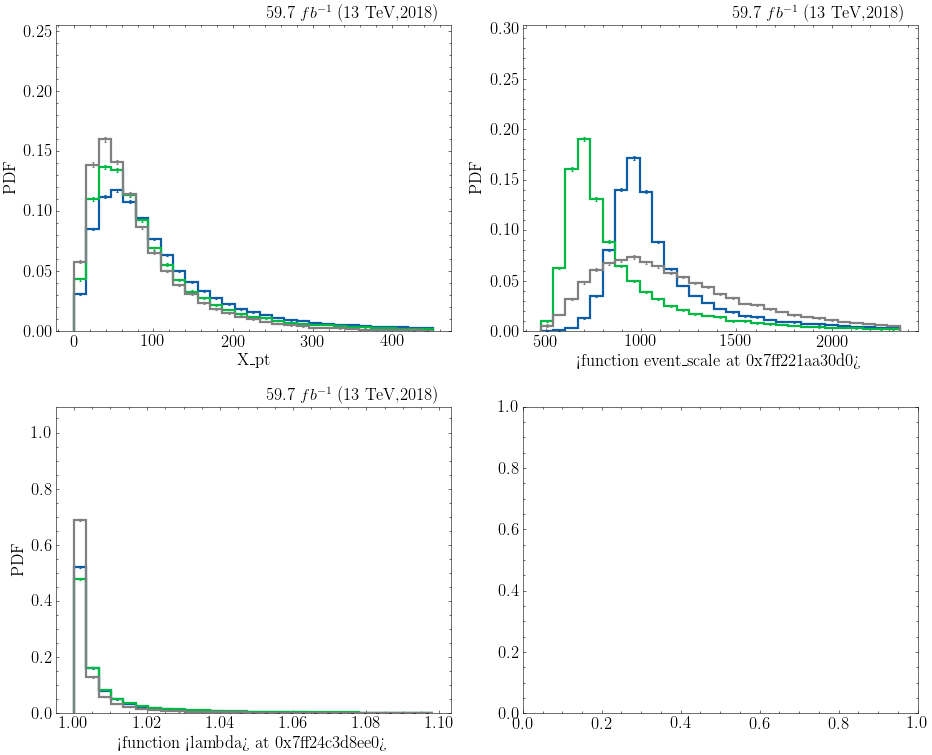

In [31]:
def event_scale(t):
    return np.sqrt( t.X_m**2 + t.X_pt**2 )

study.quick(
  signal+qcd,
  varlist=['X_pt',event_scale, lambda t:event_scale(t)/t.X_m],
  efficiency=True,
)

100%|██████████| 40/40 [00:51<00:00,  1.28s/it]


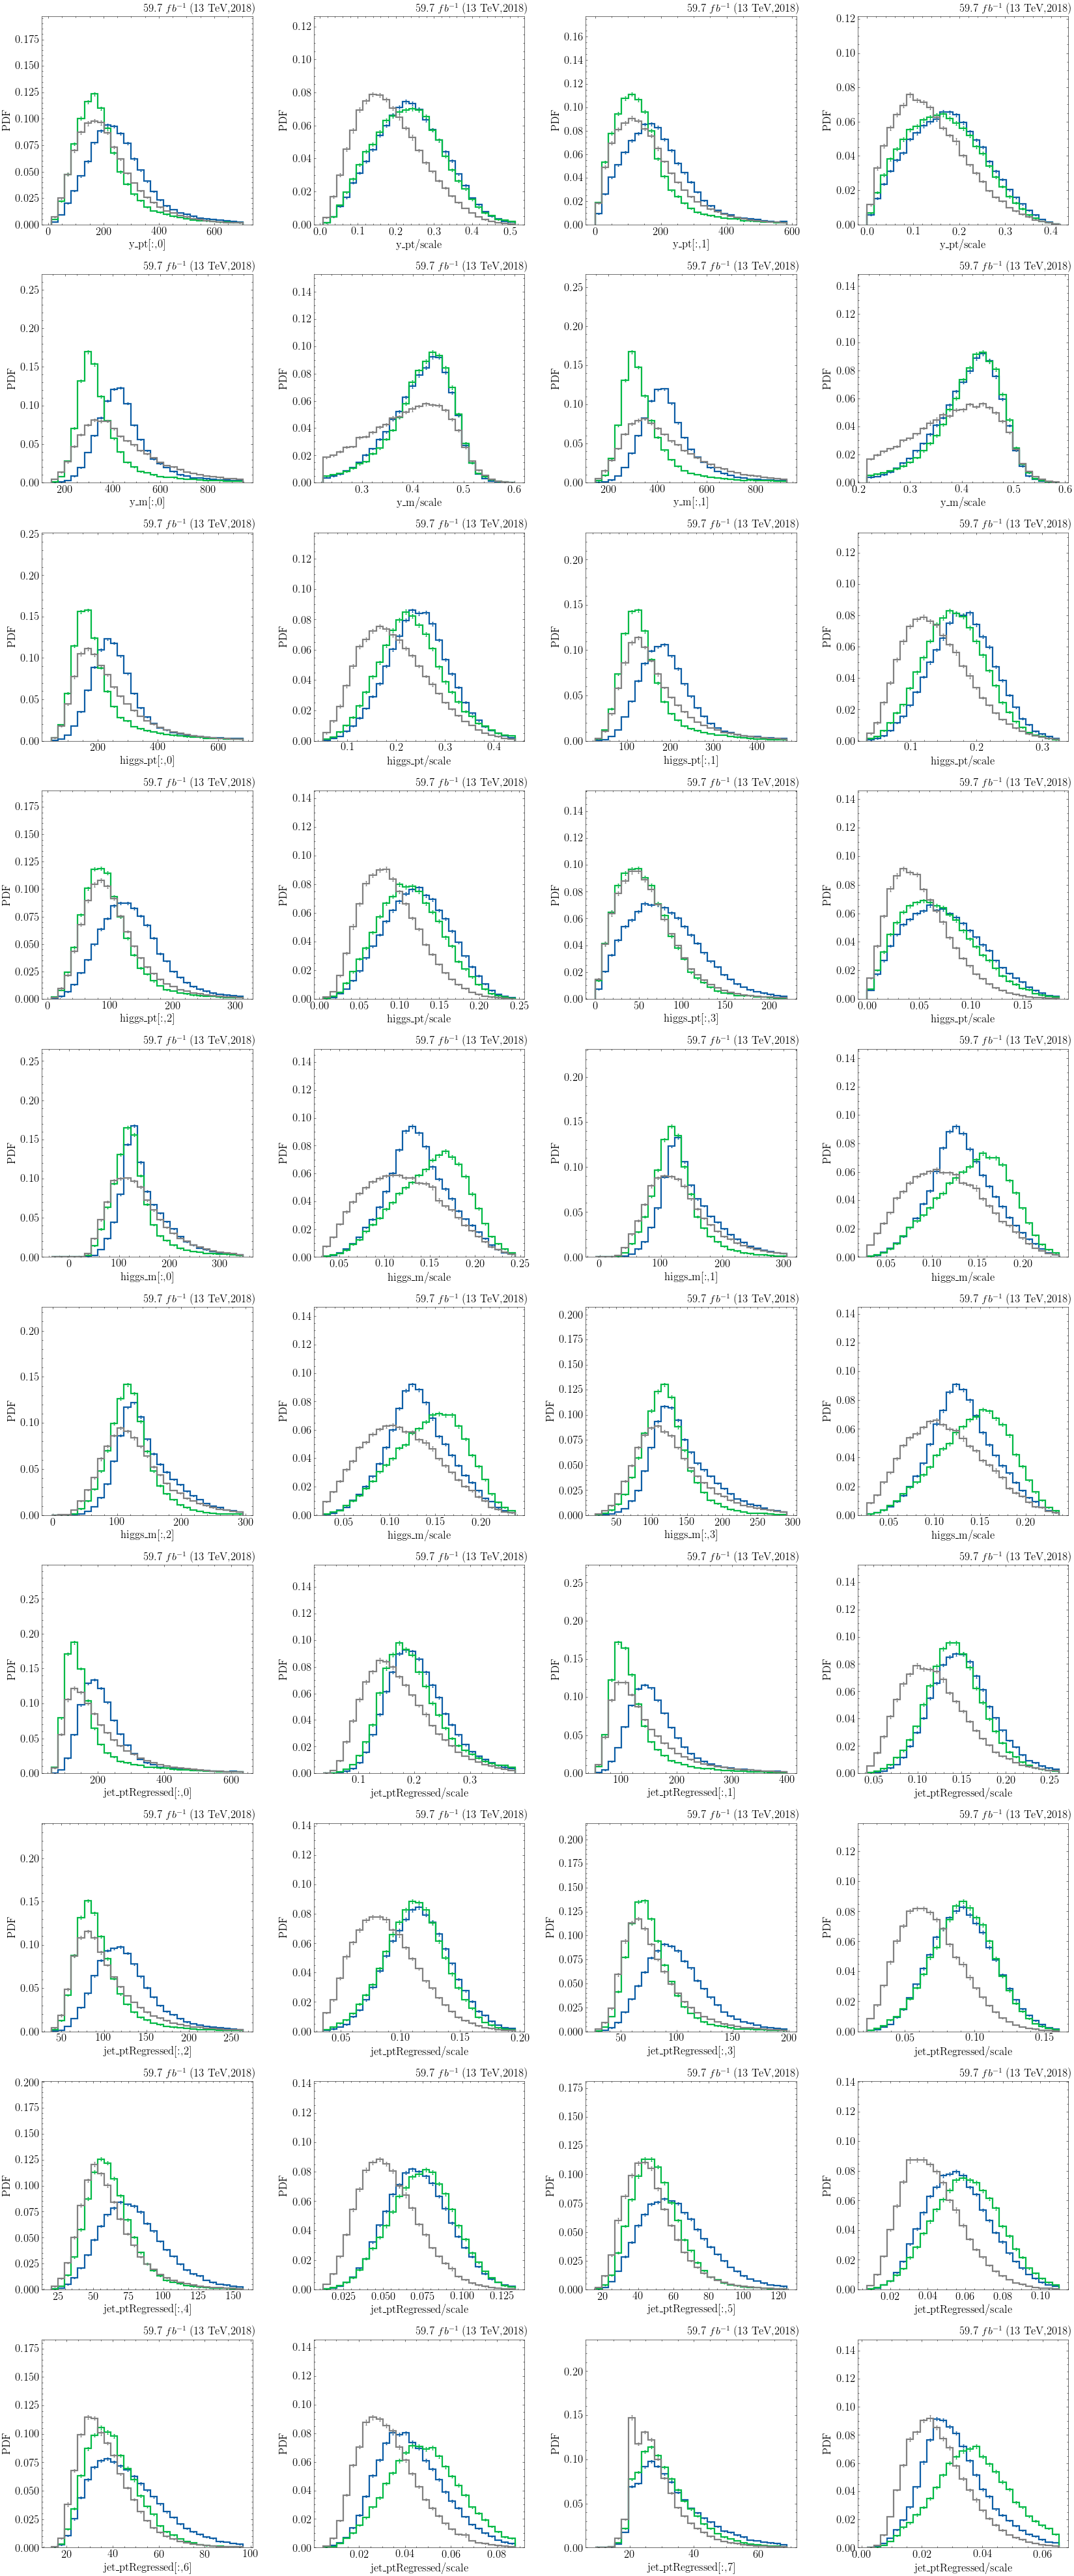

In [27]:


class event_unit(ObjTransform):
  def init(self): self.xlabel = f'{self.v}/scale'
  def __call__(self, t):
    var = t[self.v]/event_scale(t)
    if hasattr(self, 'i'): var = var[:,self.i]
    return var

varlist = flatten([ [f'y_{kin}[:,{i}]', event_unit(v=f'y_{kin}',i=i)] for kin in ('pt','m') for i in range(2)] + 
                  [ [f'higgs_{kin}[:,{i}]', event_unit(v=f'higgs_{kin}',i=i)] for kin in ('pt','m') for i in range(4)] +
                  [ [f'jet_ptRegressed[:,{i}]', event_unit(v='jet_ptRegressed',i=i),] for i in range(8)]
)

study.quick(
  signal+qcd, 
  varlist=varlist,
  dim=(-1,4),
  efficiency=True,
)

100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


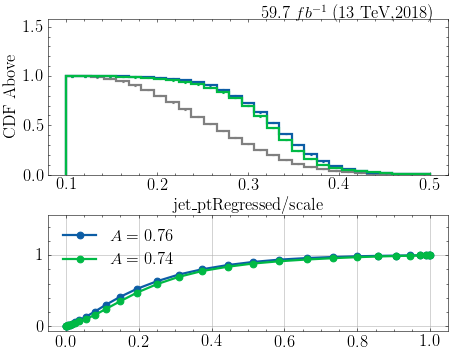

In [41]:
varlist = [event_unit(v='jet_ptRegressed')]

study.quick(
  qcd+signal, 
  transforms=lambda v : np.sqrt( ak.sum(v**2,axis=-1) ),
  varlist=varlist,
  binlist=[(0.1,0.5,30)],
  efficiency=True,

  cumulative=-1,
  correlation=True,

)